In [186]:
# Inspect data and plot figures
from collections import defaultdict

import numpy as np

import matplotlib.pyplot as plt
plt.style.use("seaborn-poster")
plt.rcParams["figure.figsize"] = (10, 6)

import pandas as pd

# Paths to data
base = "../data/base.csv"
opt = "../data/opt.csv"
seq = "../data/sequential.csv"

# Load data
base = pd.read_csv(base, header=None)
opt = pd.read_csv(opt, header=None)
seq = pd.read_csv(seq, header=None)

header = ["SIZE", "NODES", "CPUS_PER_NODE", "NBODIES", "RTIME", "GLOPS"]
base.set_axis(header, axis=1, inplace=True)
opt.set_axis(header, axis=1, inplace=True)
seq.set_axis(["NBODIES", "RTIME", "GFLOPS"], axis=1, inplace=True)

In [187]:
def speedup(serial_rtime: float, parallel_rtime: float) -> float:
    return serial_rtime/parallel_rtime


def efficiency(speedup_val: float, n_procs: int) -> float:
    return speedup_val/n_procs


def generic_performance_plot(df: pd.DataFrame, plot_ideal_performance: bool, *args, **kwargs):
    """Plot plot nprocs on x-axi, performance metric on y axis, and use df index as legend.
    
    Args:
        df: Data to plot.
        plot_ideal_performance: True to plot linear metric, false otherwise.
        *args: For MPL.
        **kwargs: For MPL.

    Returns:
        Figure and axes for performance plot
    """
    fig, ax = plt.subplots()

    x_data = np.array([int(it) for it in df.columns])
    print(x_data)
    for row_index, metric in df.iterrows():
        ax.plot(x_data, metric.values, label=row_index, *args, **kwargs)

    if plot_ideal_performance:
        ax.plot(x_data, x_data, "--", color="k", alpha=0.50, label="Ideal")

    return fig, ax

# Describe
## Initial Observations
* Min and Max of Optimized rtime is lower
* Mean of optimized program is actually lower
* How does scalability compare (i.e., as N increases, how do the strategies compare w.r.t rtime)?

## What Should Figures Show
* Speedup = serial rtime / parallel rtime # @ n-processes
* Efficiency = Speedup / n-processes
* Hard vs. Weak Scaling
* Serial Performance

In [188]:
base.describe()

,SIZE,NODES,CPUS_PER_NODE,NBODIES,RTIME,GLOPS
count,144.000000,144.000000,144.00000,144.000000,144.000000,144.000000
mean,35.000000,4.402778,6.75000,3908.000000,35.115382,1.761667
std,38.929738,2.348395,6.67057,3788.029434,84.855694,1.966040
min,2.000000,2.000000,1.00000,512.000000,0.180000,0.170000
25%,7.500000,2.000000,1.00000,896.000000,0.664500,0.520000
50%,20.000000,4.000000,4.00000,2560.000000,2.864500,0.955000
75%,40.000000,6.000000,16.00000,5572.000000,24.700000,2.260000
max,128.000000,8.000000,16.00000,10000.000000,505.927000,9.080000


In [189]:
base[(base["NBODIES"] == 10000) & (base["SIZE"] == 2)]["RTIME"]

36     504.297
84     503.987
132    505.927
Name: RTIME, dtype: float64

In [190]:
opt.describe()

,SIZE,NODES,CPUS_PER_NODE,NBODIES,RTIME,GLOPS
count,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000
mean,35.000000,3.791667,3.750000,3908.000000,19.378958,2.183819
std,38.929738,2.058158,5.444571,3788.029434,52.185408,2.285562
min,2.000000,2.000000,1.000000,512.000000,0.103000,0.020000
25%,7.500000,2.000000,1.000000,896.000000,2.960500,0.205000
50%,20.000000,4.000000,1.000000,2560.000000,12.013500,1.470000
75%,40.000000,4.000000,4.000000,5572.000000,16.472000,3.572500
max,128.000000,8.000000,16.000000,10000.000000,366.462000,9.340000


# Summary Statistics

In [191]:
NBODIES = base["NBODIES"].unique()
SIZE = sorted(base["SIZE"].unique())
print("NBODIES=", NBODIES)
print("SIZE=", SIZE)

# Store summary statistics
base_mean_std = {"SIZE": [], "NBODIES": [], "MEAN_RTIME": [], "STD_RTIME": []}
opt_mean_std = {"SIZE": [], "NBODIES": [], "MEAN_RTIME": [], "STD_RTIME": []}
seq_mean_std = {"NBODIES": [], "MEAN_RTIME": [], "STD_RTIME": []}

# Get summary statistics for parameters of interest
for nbody in NBODIES:
    seq_duplicated: pd.DataFrame = seq[(seq["NBODIES"] == nbody)]

    seq_mean = seq_duplicated["RTIME"].mean()
    seq_std = seq_duplicated["RTIME"].std()

    seq_mean_std["NBODIES"].append(nbody)
    seq_mean_std["MEAN_RTIME"].append(seq_mean)
    seq_mean_std["STD_RTIME"].append(seq_std)

    for size in SIZE:
        base_duplicated: pd.DataFrame = base[(base["NBODIES"] == nbody) & (base["SIZE"] == size)]
        opt_duplicated: pd.DataFrame = opt[(opt["NBODIES"] == nbody) & (opt["SIZE"] == size)]

        base_mean = base_duplicated["RTIME"].mean()
        base_std = base_duplicated["RTIME"].mean()

        opt_mean = opt_duplicated["RTIME"].mean()
        opt_std = opt_duplicated["RTIME"].std()

        base_mean_std["SIZE"].append(size)
        base_mean_std["NBODIES"].append(nbody)
        base_mean_std["MEAN_RTIME"].append(base_mean)
        base_mean_std["STD_RTIME"].append(base_std)

        opt_mean_std["SIZE"].append(size )
        opt_mean_std["NBODIES"].append(nbody)
        opt_mean_std["MEAN_RTIME"].append(opt_mean)
        opt_mean_std["STD_RTIME"].append(opt_std)

# Make dataframes
base_mean_std = pd.DataFrame(base_mean_std)
opt_mean_std = pd.DataFrame(opt_mean_std)
seq_mean_std = pd.DataFrame(seq_mean_std)

NBODIES= [  512  1024  4096 10000]
SIZE= [2, 4, 6, 8, 16, 24, 32, 64, 96, 128]


In [192]:
display(seq_mean_std)
display(base_mean_std)
display(opt_mean_std)

,NBODIES,MEAN_RTIME,STD_RTIME
0,512,1.553333,0.004933
1,1024,5.598333,0.006807
2,4096,86.540333,0.238383
3,10000,511.479333,0.552442


,SIZE,NBODIES,MEAN_RTIME,STD_RTIME
0,2,512,1.502000,1.502000
1,4,512,0.882667,0.882667
2,6,512,0.614667,0.614667
3,8,512,0.517333,0.517333
4,16,512,0.345667,0.345667
5,24,512,0.205333,0.205333
6,32,512,0.319000,0.319000
7,64,512,0.441667,0.441667
8,96,512,0.232667,0.232667
9,128,512,0.549000,0.549000


,SIZE,NBODIES,MEAN_RTIME,STD_RTIME
0,2,512,1.084667,0.024338
1,4,512,0.142667,0.001528
2,6,512,0.105000,0.001732
3,8,512,1.468500,1.464688
4,16,512,2.846333,0.028290
5,24,512,2.839000,0.042755
6,32,512,8.448333,5.982271
7,64,512,13.918000,0.151793
8,96,512,13.850667,0.073935
9,128,512,14.376667,0.116475


# Speedups and Efficiencies

In [193]:
display(seq_mean_std)
display(base_mean_std.head())
display(opt_mean_std.head())

,NBODIES,MEAN_RTIME,STD_RTIME
0,512,1.553333,0.004933
1,1024,5.598333,0.006807
2,4096,86.540333,0.238383
3,10000,511.479333,0.552442


,SIZE,NBODIES,MEAN_RTIME,STD_RTIME
0,2,512,1.502000,1.502000
1,4,512,0.882667,0.882667
2,6,512,0.614667,0.614667
3,8,512,0.517333,0.517333
4,16,512,0.345667,0.345667


,SIZE,NBODIES,MEAN_RTIME,STD_RTIME
0,2,512,1.084667,0.024338
1,4,512,0.142667,0.001528
2,6,512,0.105000,0.001732
3,8,512,1.468500,1.464688
4,16,512,2.846333,0.028290


In [194]:
# TODO: Should calculate these first and then take averagess
base_speedup_efficiency = defaultdict(list)
opt_speedup_efficiency = defaultdict(list)

for nbody in NBODIES:
    seq_mean_rtime = seq_mean_std[seq_mean_std["NBODIES"] == nbody]["MEAN_RTIME"].values[0]
    for size in SIZE:
        base_mean_rtime_at_params = base_mean_std[
            (base_mean_std["NBODIES"] == nbody) & (base_mean_std["SIZE"] == size)]["MEAN_RTIME"].values[0]
        opt_mean_rtime_at_params = opt_mean_std[
            (opt_mean_std["NBODIES"] == nbody) & (opt_mean_std["SIZE"] == size)]["MEAN_RTIME"].values[0]


        base_speedup = speedup(seq_mean_rtime, base_mean_rtime_at_params)
        base_efficiency = efficiency(base_speedup, size)
        opt_speedup = speedup(seq_mean_rtime, opt_mean_rtime_at_params)
        opt_efficiency = efficiency(opt_speedup, size)

        base_speedup_efficiency["SIZE"].append(size)
        base_speedup_efficiency["NBODIES"].append(nbody)
        base_speedup_efficiency["SPEEDUP"].append(base_speedup)
        base_speedup_efficiency["EFFICIENCY"].append(base_efficiency)

        opt_speedup_efficiency["SIZE"].append(size)
        opt_speedup_efficiency["NBODIES"].append(nbody)
        opt_speedup_efficiency["SPEEDUP"].append(opt_speedup)
        opt_speedup_efficiency["EFFICIENCY"].append(opt_efficiency)

# make dataframes
base_speedup_efficiency = pd.DataFrame(base_speedup_efficiency)
opt_speedup_efficiency = pd.DataFrame(opt_speedup_efficiency)

In [195]:
base_speedup_efficiency

,SIZE,NBODIES,SPEEDUP,EFFICIENCY
0,2,512,1.034177,0.517088
1,4,512,1.759819,0.439955
2,6,512,2.527115,0.421186
3,8,512,3.002577,0.375322
4,16,512,4.493732,0.280858
5,24,512,7.564935,0.315206
6,32,512,4.869383,0.152168
7,64,512,3.516981,0.054953
8,96,512,6.676218,0.069544
9,128,512,2.829387,0.022105


# Tables

In [196]:
# For presentation
base_speedup_presentation = {p: [] for p in SIZE}
base_efficiency_presentation = {p: [] for p in SIZE}
base_rtime_presentation = {p: [] for p in [1] + SIZE}

opt_speedup_presentation = {p: [] for p in SIZE}
opt_efficiency_presentation = {p: [] for p in SIZE}
opt_rtime_presentation = {p: [] for p in [1] + SIZE}

for nbody in NBODIES:
    for size in SIZE:
        # speedup and efficiency entries
        base_speedup_efficiency_at_params = base_speedup_efficiency[
            (base_speedup_efficiency["NBODIES"] == nbody) 
            & (base_speedup_efficiency["SIZE"] == size)]
        opt_speedup_efficiency_at_params = opt_speedup_efficiency[
            (opt_speedup_efficiency["NBODIES"] == nbody) 
            & (opt_speedup_efficiency["SIZE"] == size)]

        # runtime entries
        base_mean_rtime_at_params = round(base_mean_std[
            (base_mean_std["NBODIES"] == nbody) & (base_mean_std["SIZE"] == size)]["MEAN_RTIME"].values[0],
            2)
        opt_mean_rtime_at_params = round(opt_mean_std[
            (opt_mean_std["NBODIES"] == nbody) & (opt_mean_std["SIZE"] == size)]["MEAN_RTIME"].values[0],
            2)

        # Get presentable speedup and efficiencies
        base_speedup_at_params = round(base_speedup_efficiency_at_params["SPEEDUP"].values[0], 2)
        base_efficiency_at_params = round(base_speedup_efficiency_at_params["EFFICIENCY"].values[0] * 100, 2)

        opt_speedup_at_params = round(opt_speedup_efficiency_at_params["SPEEDUP"].values[0], 2)
        opt_efficiency_at_params = round(opt_speedup_efficiency_at_params["EFFICIENCY"].values[0] * 100, 2)

        # Update the presentation dicts
        base_speedup_presentation[size].append(base_speedup_at_params)
        base_efficiency_presentation[size].append(base_efficiency_at_params)
        base_rtime_presentation[size].append(base_mean_rtime_at_params)

        opt_speedup_presentation[size].append(opt_speedup_at_params)
        opt_efficiency_presentation[size].append(opt_efficiency_at_params)
        opt_rtime_presentation[size].append(opt_mean_rtime_at_params)

# update the first size entry of the runtime dataframe with the entries
# from the sequential entry
base_rtime_presentation[1] = seq_mean_std["MEAN_RTIME"].apply(lambda ele: round(ele, 2))
opt_rtime_presentation[1] = seq_mean_std["MEAN_RTIME"].apply(lambda ele: round(ele, 2))

# cast to dataframes and set indices
base_speedup_presentation = pd.DataFrame(base_speedup_presentation)
base_speedup_presentation.set_index(NBODIES, inplace=True)

base_efficiency_presentation = pd.DataFrame(base_efficiency_presentation)
base_efficiency_presentation.set_index(NBODIES, inplace=True) 

base_rtime_presentation = pd.DataFrame(base_rtime_presentation)
base_rtime_presentation.set_index(NBODIES, inplace=True)

opt_speedup_presentation = pd.DataFrame(opt_speedup_presentation)
base_speedup_presentation.set_index(NBODIES, inplace=True)

opt_efficiency_presentation = pd.DataFrame(opt_efficiency_presentation)
opt_efficiency_presentation.set_index(NBODIES, inplace=True) 

opt_rtime_presentation = pd.DataFrame(opt_rtime_presentation)
opt_rtime_presentation.set_index(NBODIES, inplace=True)


In [197]:
print("Base Speedup, Efficiency, and Runtimes")
display(base_speedup_presentation)
display(base_efficiency_presentation)
display(base_rtime_presentation)
print()
print("OpenMP Optimized Speedup, Efficiency, and Runtimes") 
display(opt_speedup_presentation)
display(opt_efficiency_presentation)
display(opt_rtime_presentation)

Base Speedup, Efficiency, and Runtimes


,2,4,6,8,16,24,32,64,96,128
512,1.03,1.76,2.53,3.00,4.49,7.56,4.87,3.52,6.68,2.83
1024,1.02,1.95,2.79,3.46,5.74,8.19,8.14,10.95,19.90,6.22
4096,1.02,2.03,3.02,3.91,7.60,11.31,13.10,22.45,30.38,32.65
10000,1.01,2.02,3.01,3.94,7.57,11.46,13.77,24.99,36.96,45.49


,2,4,6,8,16,24,32,64,96,128
512,51.71,44.00,42.12,37.53,28.09,31.52,15.22,5.50,6.95,2.21
1024,51.08,48.76,46.55,43.20,35.89,34.12,25.44,17.11,20.73,4.86
4096,50.99,50.71,50.39,48.83,47.52,47.11,40.94,35.08,31.65,25.51
10000,50.67,50.57,50.21,49.31,47.30,47.76,43.03,39.05,38.50,35.54


,1,2,4,6,8,16,24,32,64,96,128
512,1.55,1.50,0.88,0.61,0.52,0.35,0.21,0.32,0.44,0.23,0.55
1024,5.60,5.48,2.87,2.00,1.62,0.98,0.68,0.69,0.51,0.28,0.90
4096,86.54,84.86,42.67,28.63,22.15,11.38,7.65,6.61,3.86,2.85,2.65
10000,511.48,504.74,252.84,169.79,129.65,67.58,44.62,37.14,20.47,13.84,11.24



OpenMP Optimized Speedup, Efficiency, and Runtimes


,2,4,6,8,16,24,32,64,96,128
0,1.43,10.89,14.79,1.06,0.55,0.55,0.18,0.11,0.11,0.11
1,1.42,13.93,19.67,3.40,1.86,1.90,0.65,0.39,0.40,0.39
2,1.40,17.05,25.51,16.38,15.31,18.35,7.53,5.25,5.57,5.57
3,1.40,17.84,22.21,20.28,28.09,38.82,19.46,18.09,21.78,23.67


,2,4,6,8,16,24,32,64,96,128
512,71.60,272.20,246.56,13.22,3.41,2.28,0.57,0.17,0.12,0.08
1024,71.10,348.16,327.77,42.47,11.61,7.93,2.04,0.61,0.42,0.30
4096,70.03,426.31,425.18,204.75,95.70,76.45,23.55,8.21,5.81,4.35
10000,69.83,446.01,370.15,253.52,175.56,161.73,60.80,28.26,22.69,18.49


,1,2,4,6,8,16,24,32,64,96,128
512,1.55,1.08,0.14,0.10,1.47,2.85,2.84,8.45,13.92,13.85,14.38
1024,5.60,3.94,0.40,0.28,1.65,3.01,2.94,8.56,14.31,14.05,14.45
4096,86.54,61.78,5.08,3.39,5.28,5.65,4.72,11.49,16.47,15.53,15.54
10000,511.48,366.23,28.67,23.03,25.22,18.21,13.18,26.29,28.28,23.48,21.61


# Figures

[  2   4   6   8  16  24  32  64  96 128]


Text(0, 0.5, 'Speedup')

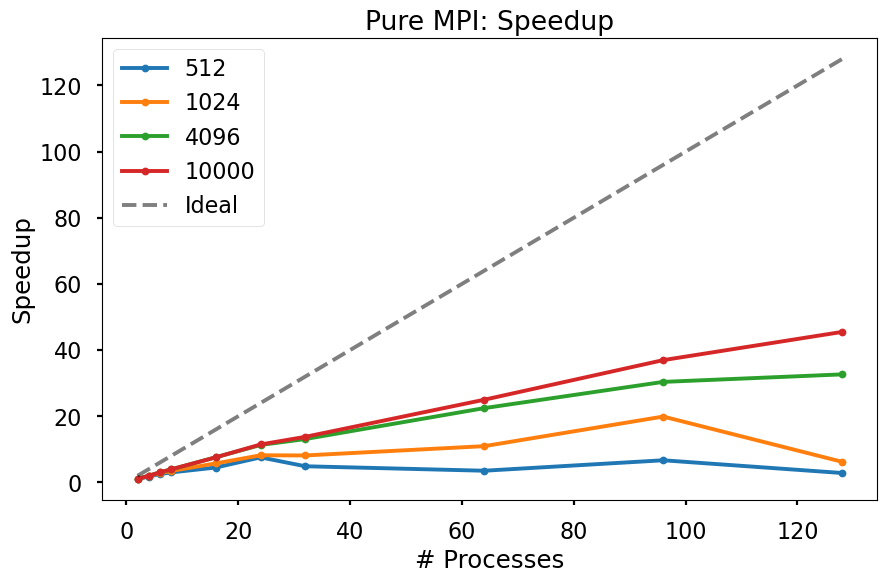

In [198]:
# Plots for base
fig_base_speedup, ax_base_speedup = generic_performance_plot(base_speedup_presentation, True, ".-")
ax_base_speedup.legend()
ax_base_speedup.set_title("Pure MPI: Speedup")
ax_base_speedup.set_xlabel("# Processes")
ax_base_speedup.set_ylabel("Speedup")

[  2   4   6   8  16  24  32  64  96 128]


Text(0, 0.5, 'Efficiency')

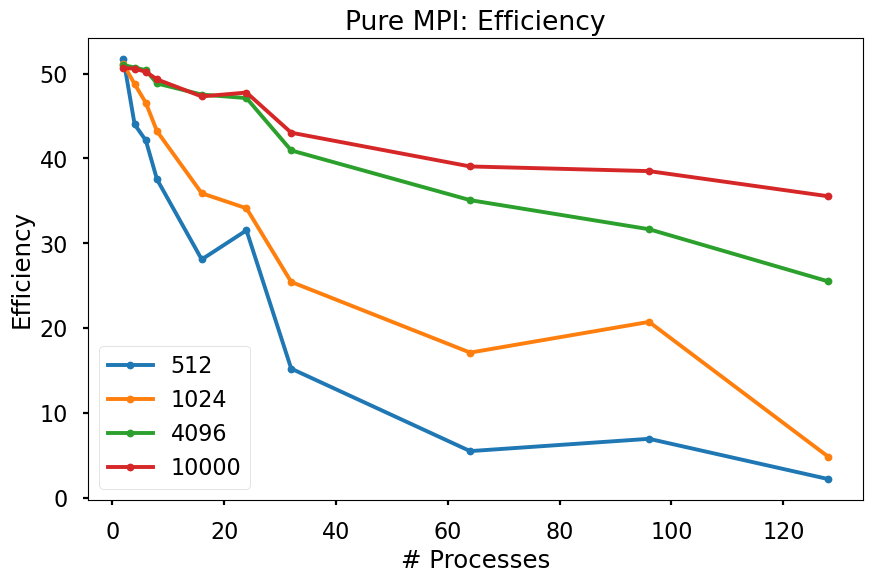

In [199]:
# Efficiencies
fig_base_efficiency, ax_base_efficiency = generic_performance_plot(base_efficiency_presentation, False, ".-")
ax_base_efficiency.legend()
ax_base_efficiency.set_title("Pure MPI: Efficiency")
ax_base_efficiency.set_xlabel("# Processes")
ax_base_efficiency.set_ylabel("Efficiency")

[  1   2   4   6   8  16  24  32  64  96 128]


Text(0, 0.5, 'Runtime (s)')

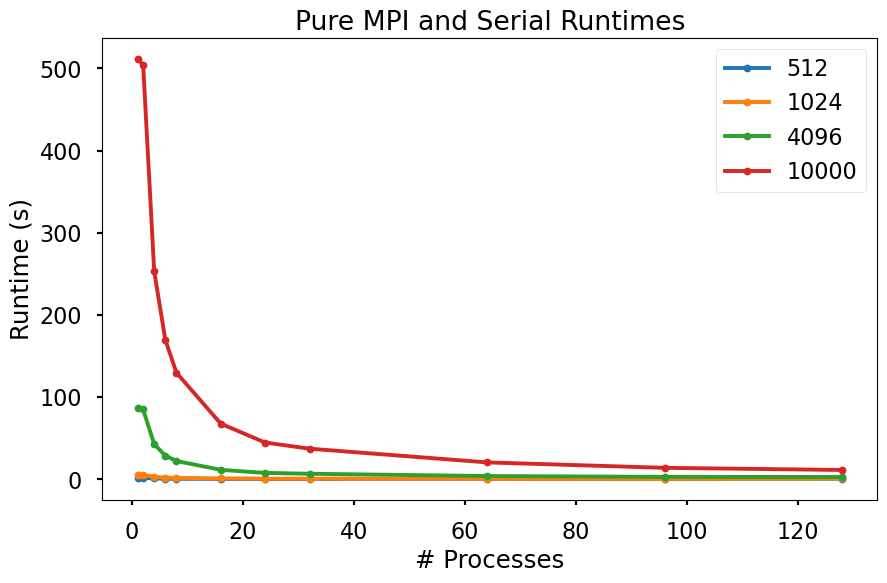

In [200]:
# Run times
fig_base_rtime, ax_base_rtime = generic_performance_plot(base_rtime_presentation, False, ".-")
ax_base_rtime.legend()
ax_base_rtime.set_title("Pure MPI and Serial Runtimes")
ax_base_rtime.set_xlabel("# Processes")
ax_base_rtime.set_ylabel("Runtime (s)")